<a href="https://colab.research.google.com/github/Ramakrish21/plant-disease-predictor/blob/main/training_model_image_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Ramakrish21/plant-disease-predictor.git

Cloning into 'plant-disease-predictor'...
remote: Enumerating objects: 23461, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 23461 (delta 2), reused 0 (delta 0), pack-reused 23453 (from 6)
Receiving objects: 100% (23461/23461), 556.18 MiB | 31.14 MiB/s, done.
Resolving deltas: 100% (175/175), done.
Updating files: 100% (45910/45910), done.
Filtering content: 100% (24/24), 200.18 MiB | 80.99 MiB/s, done.


In [2]:
%cd /content/plant-disease-predictor

/content/plant-disease-predictor


In [7]:
# ✅ Cell 1 - Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import HTML

DATA_DIR = '/content/plant-disease-predictor/ai-service/data/processed'

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=35



In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 5 classes.


In [9]:
class_names = dataset.class_names
class_names

['Early_Blight_Mild',
 'Early_Blight_Severe',
 'Healthy',
 'Late_Blight_Mild',
 'Late_Blight_Severe']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 4 4 1 0 1 1 1 3 4 3 4 1 4 1 4 4 3 1 3 0 4 1 1 4 1 1 2 4 4 1 1]


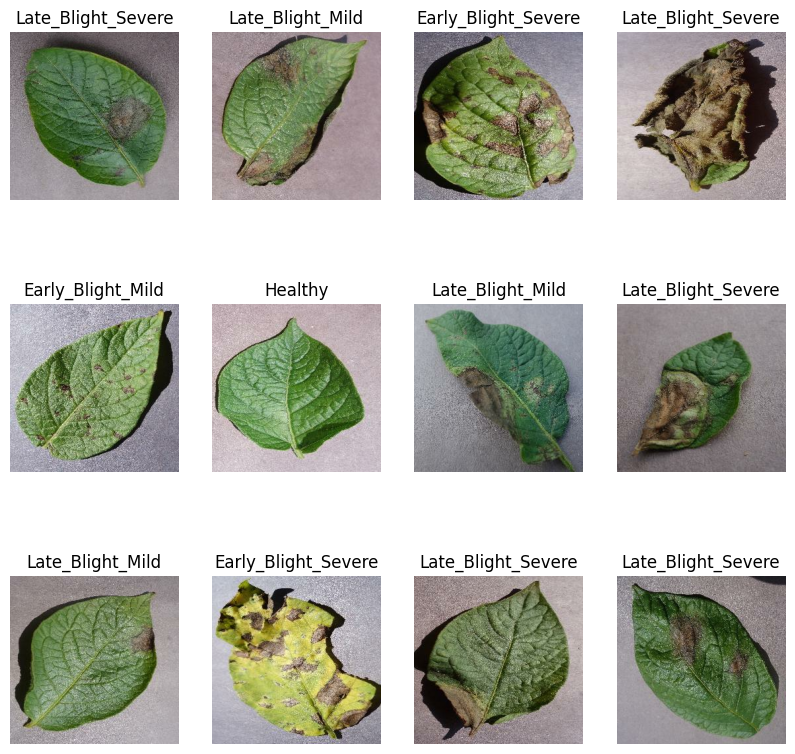

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

68

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)


6

In [24]:
len(test_ds)

8

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=35,
)

Epoch 1/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 414ms/step - accuracy: 0.3258 - loss: 1.4696 - val_accuracy: 0.4688 - val_loss: 1.1789
Epoch 2/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.4783 - loss: 1.2558 - val_accuracy: 0.5260 - val_loss: 1.0927
Epoch 3/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 336ms/step - accuracy: 0.5148 - loss: 1.1475 - val_accuracy: 0.5469 - val_loss: 1.0132
Epoch 4/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.6217 - loss: 0.9530 - val_accuracy: 0.6458 - val_loss: 0.9006
Epoch 5/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.6583 - loss: 0.8402 - val_accuracy: 0.6667 - val_loss: 0.7839
Epoch 6/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.6906 - loss: 0.7721 - val_accuracy: 0.7448 - val_loss: 0.6189
Epoch 7/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - accuracy: 0.7234 - loss: 0.6495 - val_accuracy: 0.7344 - val_loss: 0.5857
Epoch 8/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.7328 - loss: 0.6218 - val_accu

In [36]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8338 - loss: 0.3533


In [37]:
scores

[0.3178078830242157, 0.8515625]

In [38]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

35

In [42]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.4043564796447754,
 1.2111579179763794,
 1.0631455183029175,
 0.921582818031311,
 0.8219742178916931]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

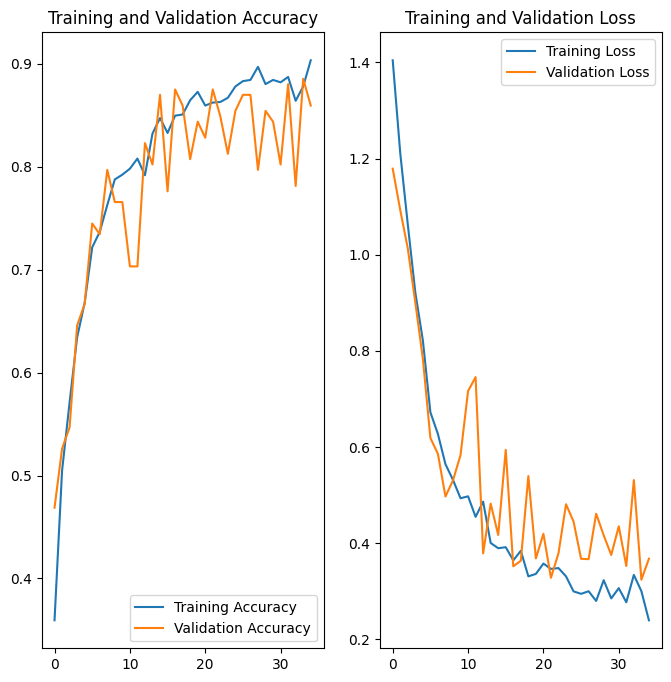

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Late_Blight_Mild
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
predicted label: Late_Blight_Mild


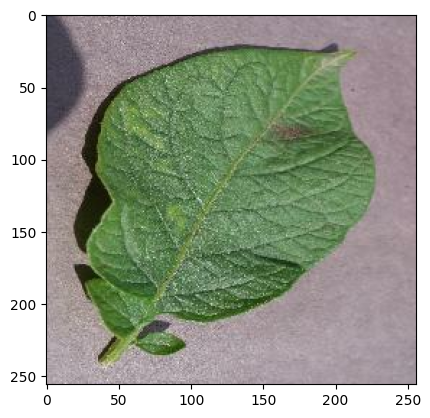

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


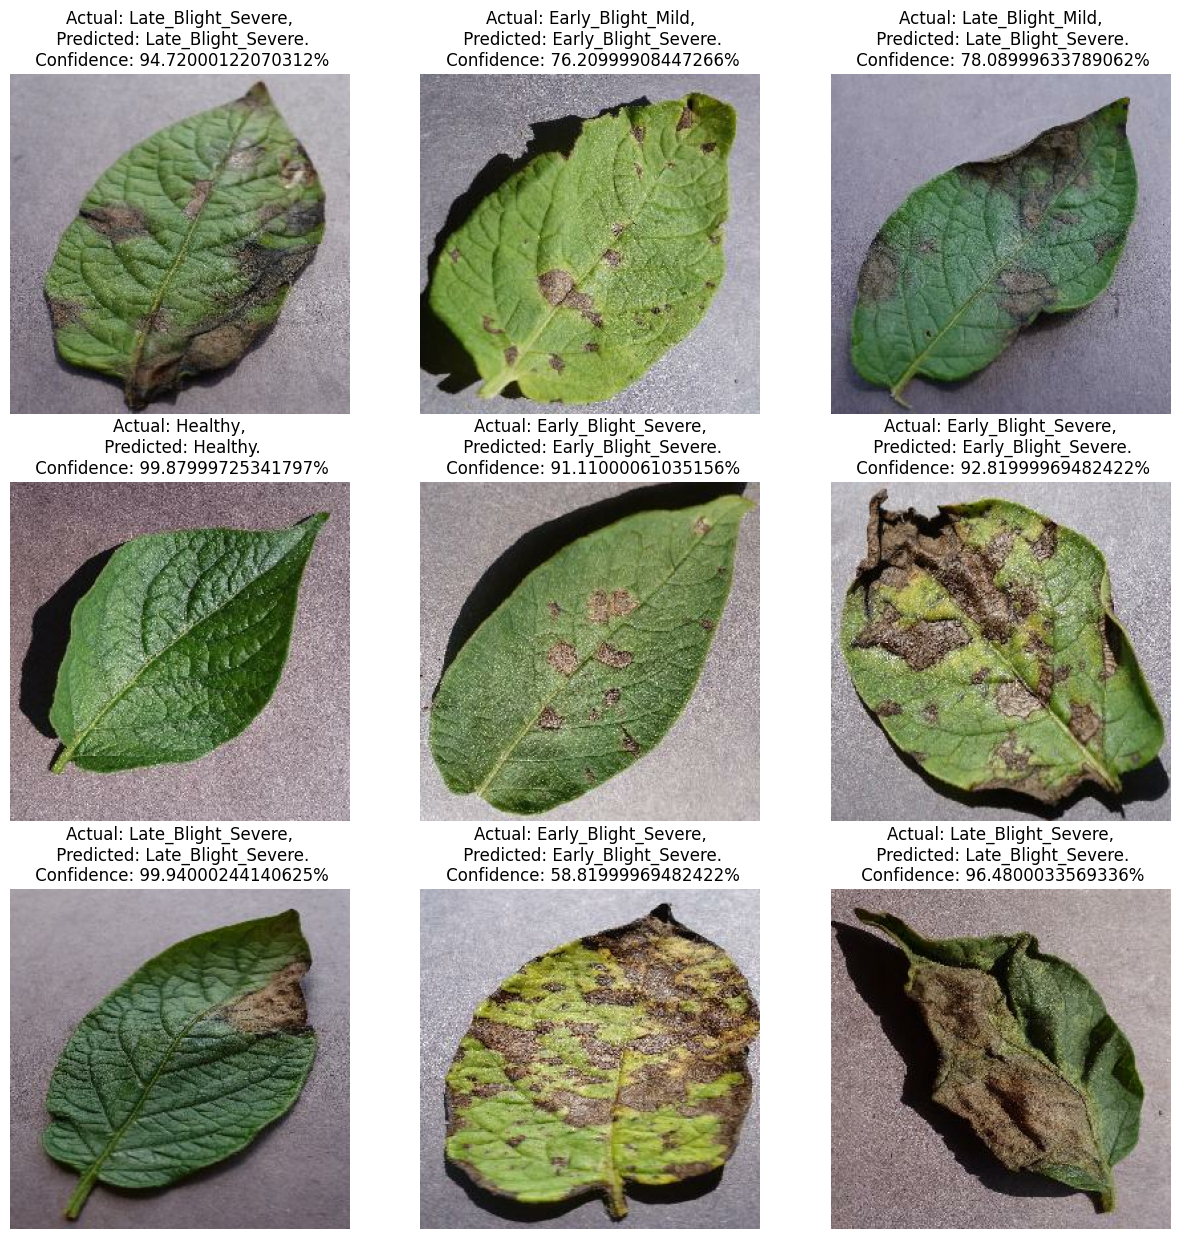

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [48]:
model.save("/content/plant-disease-predictor/ai-service/ai-model/Model/potatoes_trained_model.h5")

✅ Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


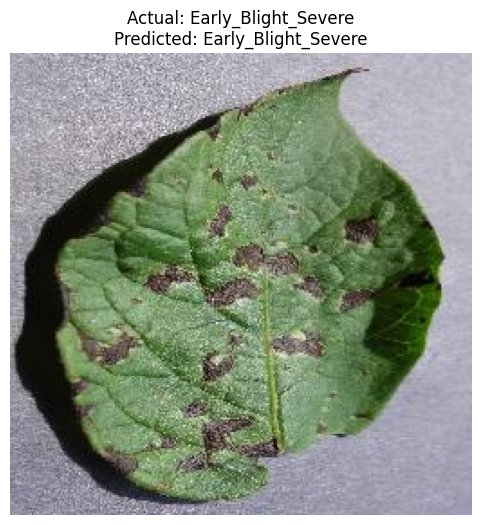

----------------------------------------
  Actual Class:    Early_Blight_Severe
  Predicted Class: Early_Blight_Severe
----------------------------------------


In [52]:
# In a new Colab cell
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# --- 1. CONFIGURATION ---
MODEL_PATH = "/content/plant-disease-predictor/ai-service/ai-model/Model/potatoes_trained_model.h5"
CLASS_NAMES = ['Early_Blight_Mild', 'Early_Blight_Severe', 'Healthy', 'Late_Blight_Mild', 'Late_Blight_Severe']
IMAGE_SIZE = 256

# --- 2. LOAD THE SAVED MODEL ---
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")

# --- 3. THE INFERENCE FUNCTION (UPDATED) ---
def predict_image_with_actual(image_path, loaded_model):
    """Loads, preprocesses, and predicts a single image, then compares to its actual class."""
    try:
        # Get the Actual Class from the folder name
        actual_class = os.path.basename(os.path.dirname(image_path))

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Create a batch

        # Make the prediction
        predictions = loaded_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Get only the predicted class name
        predicted_class = CLASS_NAMES[np.argmax(score)]

        # --- Display the results (Confidence Removed) ---
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        # Updated title to remove confidence
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
        plt.axis("off")
        plt.show()

        # Print a clean summary table (Confidence Removed)
        print("-" * 40)
        print(f"  Actual Class:    {actual_class}")
        print(f"  Predicted Class: {predicted_class}")
        print("-" * 40)

    except FileNotFoundError:
        print(f"Error: Test image not found at '{image_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

# --- 4. RUN THE PREDICTION ---
# ❗️ IMPORTANT: Change this path to any image inside your '/content/processed_data/' folder
TEST_IMAGE_PATH = '/content/plant-disease-predictor/ai-service/data/processed/Early_Blight_Severe/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG'

if 'model' in locals():
    predict_image_with_actual(TEST_IMAGE_PATH, model)

In [4]:
%%writefile /content/plant-disease-predictor/ai-service/ai-model/scripts/label_severity.py
import os
import cv2
import numpy as np
import shutil

# --- CONFIGURATION ---
RAW_DIR = '/content/plant-disease-predictor/ai-service/data/raw'
PROCESSED_DIR = '/content/plant-disease-predictor/ai-service/data/processed'
# This threshold is now for our more advanced score, so we can start with a lower value.
SEVERE_THRESHOLD = 0.12

# Weights for our "Smart Score". This tells the algorithm what's most important.
WEIGHTS = {
    'total_area': 0.5,
    'lesion_count': 0.2,
    'max_lesion_area': 0.3
}

def calculate_smart_severity(image_path):
    """
    Calculates a nuanced severity score based on lesion analysis.
    Returns a score between 0 and 1.
    """
    image = cv2.imread(image_path)
    if image is None:
        return 0.0

    image_area = image.shape[0] * image.shape[1]

    # 1. More Robust Spot Detection
    # Convert to HSV color space, which is better for color-based filtering
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define a range for brown/black colors (typical for disease spots)
    lower_bound = np.array([10, 50, 20])
    upper_bound = np.array([30, 255, 200]) # Wider range for browns
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Add another mask for very dark spots
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, dark_mask = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY_INV)

    # Combine the masks
    combined_mask = cv2.bitwise_or(mask, dark_mask)

    # Clean the mask to remove noise
    kernel = np.ones((3,3), np.uint8)
    cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

    # 2. Find Individual Lesions (Contours)
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out very small contours (noise) and very large ones (background)
    min_area = 50
    max_area = image_area * 0.5
    lesions = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

    if not lesions:
        return 0.0

    # 3. Calculate Advanced Metrics
    total_lesion_area = sum(cv2.contourArea(c) for c in lesions)
    lesion_count = len(lesions)
    max_lesion_area = max(cv2.contourArea(c) for c in lesions)

    # 4. Normalize metrics and calculate final score
    norm_total_area = total_lesion_area / image_area
    # Normalize count by a plausible max (e.g., 50 spots)
    norm_lesion_count = min(lesion_count / 50.0, 1.0)
    norm_max_area = max_lesion_area / image_area

    severity_score = (WEIGHTS['total_area'] * norm_total_area +
                      WEIGHTS['lesion_count'] * norm_lesion_count +
                      WEIGHTS['max_lesion_area'] * norm_max_area)

    return severity_score


def main():
    """Main function to process all folders."""
    if os.path.exists(PROCESSED_DIR):
        shutil.rmtree(PROCESSED_DIR) # Start fresh

    CLASSES = {
        'Potato___Early_blight': ('Early_Blight_Mild', 'Early_Blight_Severe'),
        'Potato___Late_blight': ('Late_Blight_Mild', 'Late_Blight_Severe'),
        'Potato___healthy': ('Healthy', None)
    }

    print("Starting smart image sorting...")
    for raw_folder, (mild, severe) in CLASSES.items():
        source_path = os.path.join(RAW_DIR, raw_folder)
        if not os.path.isdir(source_path): continue

        # Create destination folders
        if mild: os.makedirs(os.path.join(PROCESSED_DIR, mild), exist_ok=True)
        if severe: os.makedirs(os.path.join(PROCESSED_DIR, severe), exist_ok=True)

        for filename in os.listdir(source_path):
            src_file = os.path.join(source_path, filename)
            dest_folder = mild
            if severe: # This handles the disease classes
                score = calculate_smart_severity(src_file)
                if score >= SEVERE_THRESHOLD:
                    dest_folder = severe

            shutil.copy(src_file, os.path.join(PROCESSED_DIR, dest_folder, filename))

    print("\n✅ Smart sorting complete. Final counts:")
    for folder in sorted(os.listdir(PROCESSED_DIR)):
        count = len(os.listdir(os.path.join(PROCESSED_DIR, folder)))
        print(f"- {folder}: {count} images")

if __name__ == "__main__":
    main()

Writing /content/plant-disease-predictor/ai-service/ai-model/scripts/label_severity.py


In [6]:
!python /content/plant-disease-predictor/ai-service/ai-model/scripts/label_severity.py

Starting smart image sorting...

✅ Smart sorting complete. Final counts:
- Early_Blight_Mild: 231 images
- Early_Blight_Severe: 769 images
- Healthy: 152 images
- Late_Blight_Mild: 329 images
- Late_Blight_Severe: 671 images


In [53]:
!git add ai-service/

In [55]:
  !git config --global user.email "adlaramakrishna28@gmail.com"

  !git config --global user.name "Ramakrishn21"

In [56]:
!git commit -m "model updated for acc"

[main bcb872d5] model updated for acc
 491 files changed, 118 insertions(+), 98 deletions(-)
 delete mode 100644 ai-service/ai-model/Model/best_cnn_model.h5
 delete mode 100644 ai-service/ai-model/Model/best_cnn_model.keras
 delete mode 100644 ai-service/ai-model/Model/class_names.json
 delete mode 100644 ai-service/ai-model/Model/final_cnn_model.keras
 delete mode 100644 ai-service/ai-model/Model/image_based_trained_model.keras
 create mode 100644 ai-service/ai-model/Model/potatoes_trained_model.h5
 rewrite ai-service/ai-model/scripts/label_severity.py (91%)
 rename ai-service/data/processed/{Early_Blight_Severe => Early_Blight_Mild}/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG (100%)
 rename ai-service/data/processed/{Early_Blight_Severe => Early_Blight_Mild}/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG (100%)
 rename ai-service/data/processed/{Early_Blight_Severe => Early_Blight_Mild}/05c35093-11b8-4cd0-b67a-148859754440___RS_Early.B 8939.JPG (100%)
 rena

In [63]:
!git push origin main

Uploading LFS objects: 100% (1/1), 2.3 MB | 0 B/s, done.
Enumerating objects: 26, done.
Counting objects: 100% (26/26), done.
Delta compression using up to 2 threads
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 25.60 KiB | 3.66 MiB/s, done.
Total 14 (delta 6), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (6/6), completed with 5 local objects.
To https://github.com/Ramakrish21/plant-disease-predictor.git
   84ed03fa..bcb872d5  main -> main
